In [1]:
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_recall_curve, f1_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import auc, roc_auc_score, average_precision_score
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split

import numpy as np
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler, NearMiss, CondensedNearestNeighbour
from imblearn.under_sampling import EditedNearestNeighbours, RepeatedEditedNearestNeighbours, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.ensemble import BalanceCascade, EasyEnsemble
from sklearn.ensemble import AdaBoostClassifier
import warnings
from itable import PrettyTable, TableStyle, CellStyle
import pandas as pd

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings('ignore')
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 6)
plt.style.use('fivethirtyeight')

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('./NYS_Crash_Data_1.csv')

## Create target variable

In [3]:
def injury(x):
    if x == 'O':
        return 0
    else:
        return 1

df['Injured'] = df['Injury Severity'].apply(injury)

In [4]:
def killed(x):
    if x == 'K':
        return 1
    else:
        return 0

df['Killed'] = df['Injury Severity'].apply(killed)

In [5]:
df['Injured'].value_counts() / len(df['Injured']) * 100

0    81.179932
1    18.820068
Name: Injured, dtype: float64

In [6]:
print(df.isnull().sum())

Unnamed: 0                          0
Role Type                           0
Case Individual ID                  0
Sex of Individual               27647
Engine Cylinders                61187
Number of Occupants               143
State of Registration            5697
Vehicle Make                     5583
Vehicle Year                     1715
Direction of Travel                 0
Ejection                        28724
Transported By                 103134
Victim Status                   28724
Event Descriptor                    0
Fuel Type                         143
Injury Location                 31353
Injury Descriptor               31353
Lighting Conditions                 0
Municipality                        0
Crash Descriptor                    0
Action prior to accident            0
Road Descriptor                     0
Road Surface Conditions             0
Safety Equipment                31353
Seating Position                    0
Traffic Control Device              0
Vehicle Body

In [7]:
dropped_features = ['Case Individual ID', 'State of Registration', 'hosp', 'Police Report']
df.drop(dropped_features, axis=1, inplace=True)

In [8]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [9]:
print(df.isnull().sum())

Role Type                           0
Sex of Individual               27647
Engine Cylinders                61187
Number of Occupants               143
Vehicle Make                     5583
Vehicle Year                     1715
Direction of Travel                 0
Ejection                        28724
Transported By                 103134
Victim Status                   28724
Event Descriptor                    0
Fuel Type                         143
Injury Location                 31353
Injury Descriptor               31353
Lighting Conditions                 0
Municipality                        0
Crash Descriptor                    0
Action prior to accident            0
Road Descriptor                     0
Road Surface Conditions             0
Safety Equipment                31353
Seating Position                    0
Traffic Control Device              0
Vehicle Body Type                   0
Weather Conditions                  0
Day of Week                         0
County Name 

## Encode categorical variables

In [10]:
for col_name in df.columns:
    if(df[col_name].dtype == 'object'):
        df[col_name]= df[col_name].astype('category')
        df[col_name] = df[col_name].cat.codes

### Build a heat map to look at possible correlations between features

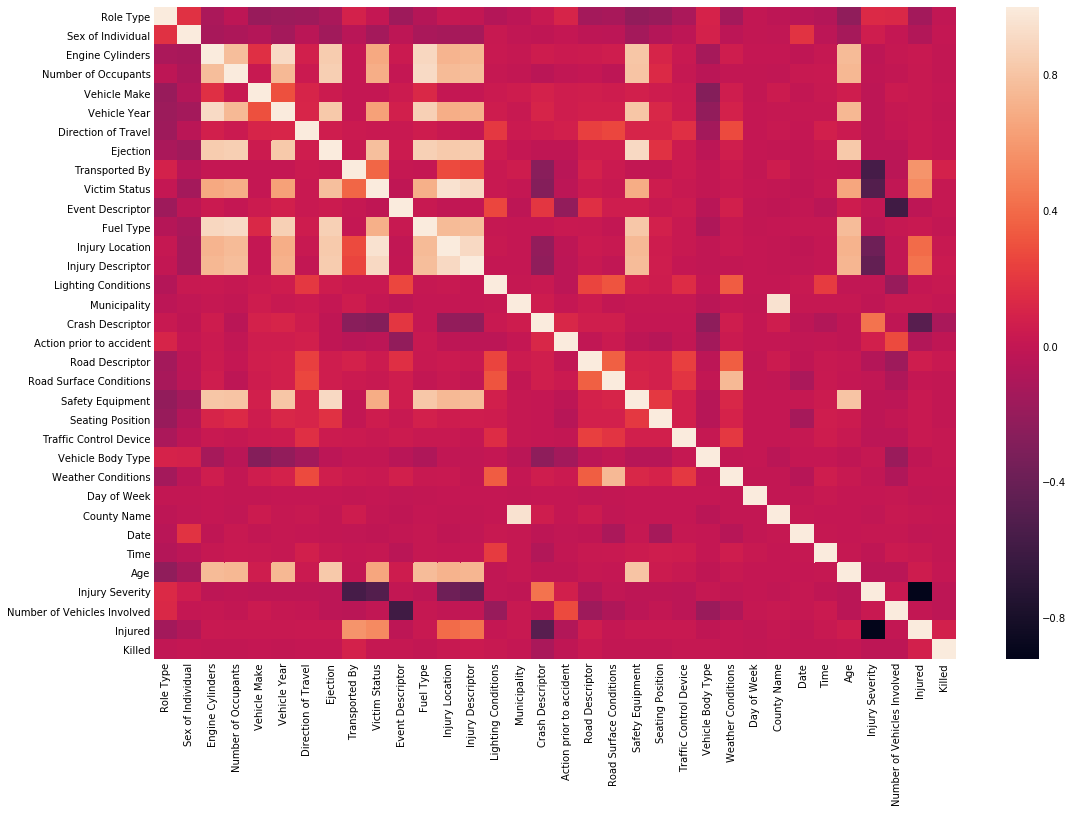

In [11]:
plt.subplots(figsize=(16,12))
heatmap_plot = sns.heatmap(df.corr())
figure = heatmap_plot.get_figure()    
figure.savefig('Correlation Heatmap Figure.png', dpi=400)

We observe several non-negligible correlations between Victim Status and Injury Descriptor, Injury Location and Injury Severity which is understandable as the Injury characteristics are closely related to the status of the victim. We will exclude Victim Status, Injury Descriptor and Injury Severity from the features used to build the model. There are some correlation between Case Individual ID and Vehicle Type but IDs will be dropped from the dataset.

In [12]:
df.head()

,Role Type,Sex of Individual,Engine Cylinders,Number of Occupants,Vehicle Make,Vehicle Year,Direction of Travel,Ejection,Transported By,Victim Status,...,Weather Conditions,Day of Week,County Name,Date,Time,Age,Injury Severity,Number of Vehicles Involved,Injured,Killed
0,1,1,13,4,222,200,10,13,-3.0,11,...,1,4,31,0,180,121,4,2,0,0
1,1,1,27,4,1012,206,4,13,-3.0,26,...,2,4,5,0,150,217,2,1,1,0
2,1,1,34,4,427,210,7,13,-3.0,11,...,4,4,13,0,159,117,4,1,0,0
3,1,1,27,3,1202,196,10,13,9997.0,26,...,1,4,31,0,295,190,2,1,1,0
4,1,0,27,3,607,196,3,13,-3.0,11,...,2,4,31,0,725,127,4,2,0,0


## Split dataset in training and test sets

In [13]:
def split_dataset(dataset, train_percentage, feature_headers, target_header):
    """
    Split dataset into train and test dataset
    """
    train_x, test_x, train_y, test_y = train_test_split(dataset[feature_headers], dataset[target_header],
                                                        train_size=train_percentage)
    return train_x, test_x, train_y, test_y

In [14]:
list(df.columns)

['Role Type',
 'Sex of Individual',
 'Engine Cylinders',
 'Number of Occupants',
 'Vehicle Make',
 'Vehicle Year',
 'Direction of Travel',
 'Ejection',
 'Transported By',
 'Victim Status',
 'Event Descriptor',
 'Fuel Type',
 'Injury Location',
 'Injury Descriptor',
 'Lighting Conditions',
 'Municipality',
 'Crash Descriptor',
 'Action prior to accident',
 'Road Descriptor',
 'Road Surface Conditions',
 'Safety Equipment',
 'Seating Position',
 'Traffic Control Device',
 'Vehicle Body Type',
 'Weather Conditions',
 'Day of Week',
 'County Name',
 'Date',
 'Time',
 'Age',
 'Injury Severity',
 'Number of Vehicles Involved',
 'Injured',
 'Killed']

## Target variable: Injured

In [15]:
headers = ['Role Type', 'Sex of Individual', 'Number of Occupants', 'Vehicle Make', 'Vehicle Year',
           'Direction of Travel', 'Ejection', 'Event Descriptor',
           'Lighting Conditions', 'Action prior to accident', 'Road Descriptor',
           'Road Surface Conditions', 'Safety Equipment', 'Seating Position','Traffic Control Device',
           'Vehicle Body Type', 'Weather Conditions', 'Day of Week', 'County Name', 'Date', 'Time',
           'Age', 'Number of Vehicles Involved', 'Injured']

In [16]:
# The last element is the target and the other elements are the predictors
train_x, test_x, train_y, test_y = split_dataset(df, 0.7, headers[:-1], headers[-1])

In [17]:
# Train and Test dataset size details
print ("Train_x Shape : ", train_x.shape)
print ("Train_y Shape : ", train_y.shape)
print ("Test_x Shape : ", test_x.shape)
print ("Test_y Shape : ", test_y.shape)

Train_x Shape :  (627141, 23)
Train_y Shape :  (627141,)
Test_x Shape :  (268775, 23)
Test_y Shape :  (268775,)


## Gradient Boosting Classifier

In [18]:
gbc = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100,max_depth=8, min_samples_split=2, 
                                      min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10)
gbc.fit(train_x,train_y)
predictors=list(train_x)

Accuracy of the GBM on test set: 0.840
              precision    recall  f1-score   support

           0       0.85      0.98      0.91    218077
           1       0.74      0.23      0.35     50698

   micro avg       0.84      0.84      0.84    268775
   macro avg       0.79      0.61      0.63    268775
weighted avg       0.83      0.84      0.80    268775



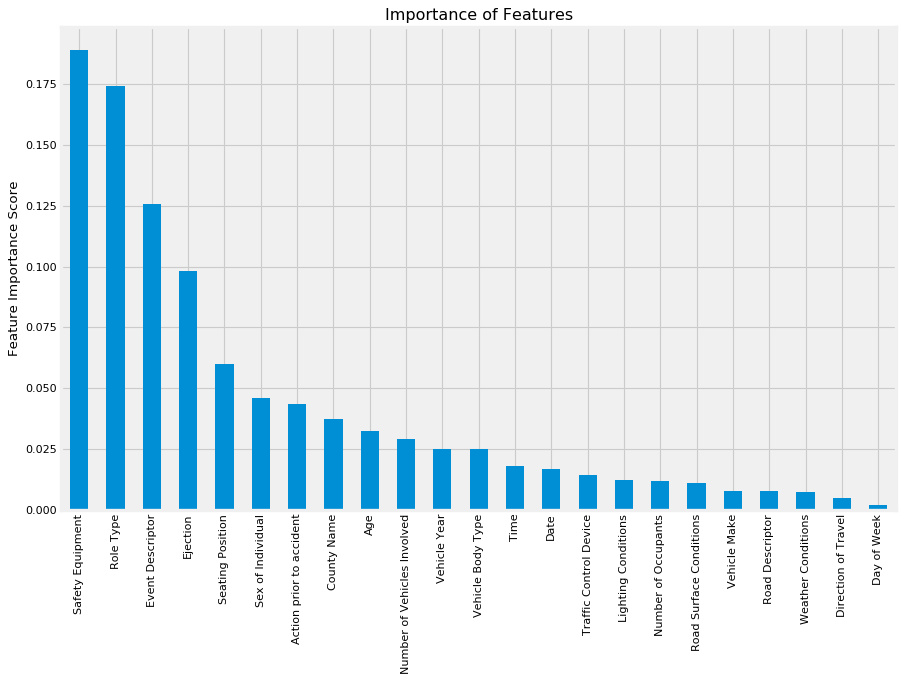

In [19]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')

feat_imp = pd.Series(gbc.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')
print('Accuracy of the GBM on test set: {:.3f}'.format(gbc.score(test_x, test_y)))
pred=gbc.predict(test_x)
print(classification_report(test_y, pred))

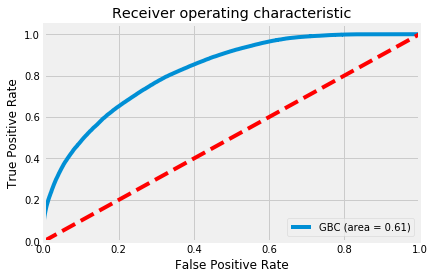

In [20]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve 

#calculate values for ROC AUC plot
gbc_roc_auc = roc_auc_score(test_y, gbc.predict(test_x))
fpr, tpr, thresholds = roc_curve(test_y, gbc.predict_proba(test_x)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='GBC (area = %0.2f)' % gbc_roc_auc)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# Random undersampling of majority class

In [21]:
us1 = RandomUnderSampler(ratio=0.8, random_state=1)
train_x_res, train_y_res = us1.fit_sample(train_x, train_y)
print("Distribution of class labels before resampling {}".format(Counter(train_y)))
print("Distribution of class labels after resampling {}".format(Counter(train_y_res)))

Distribution of class labels before resampling Counter({0: 509227, 1: 117914})
Distribution of class labels after resampling Counter({0: 147392, 1: 117914})


In [22]:
gbc1 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100,max_depth=8, min_samples_split=2, 
                                      min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10)
gbc1.fit(train_x_res,train_y_res)
predictors=list(train_x_res)

In [23]:
print('Accuracy of the GBM on test set: {:.3f}'.format(gbc1.score(test_x, test_y)))
pred=gbc1.predict(test_x)
print(classification_report(test_y, pred))

Accuracy of the GBM on test set: 0.759
              precision    recall  f1-score   support

           0       0.91      0.78      0.84    218077
           1       0.42      0.68      0.52     50698

   micro avg       0.76      0.76      0.76    268775
   macro avg       0.66      0.73      0.68    268775
weighted avg       0.82      0.76      0.78    268775

